# Neural Networks with PyTorch - Worked Example

<hr style="border:2px solid gray">

# Index: <a id='index'></a>
1. [Setting Up](#setup)
1. [PyTorch](#pytorch)
1. [Binary Classifier in PyTorch](#neuron)
1. [Building a Training Function](#trainfunc)
1. [Training](#training)
1. [Visualise What We've Done](#visual)

<hr style="border:2px solid gray">

# Setting Up [^](#index) <a id='setup'></a>

We will again begin by importing relevant modules, setting the plotting parameters for the notebook and generating a toy dataset to work with.

In [1]:
import sklearn, sklearn.datasets
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 200 


Generating toy datasets:

In [2]:
n_samples=200
np.random.seed(0) # reproducible runs for debugging

In [3]:
# our 'easy', linearly separable classification
X,Y=sklearn.datasets.make_classification(n_features=2, n_redundant=0, n_samples=n_samples,
    n_informative=2, random_state=None, n_clusters_per_class=1)

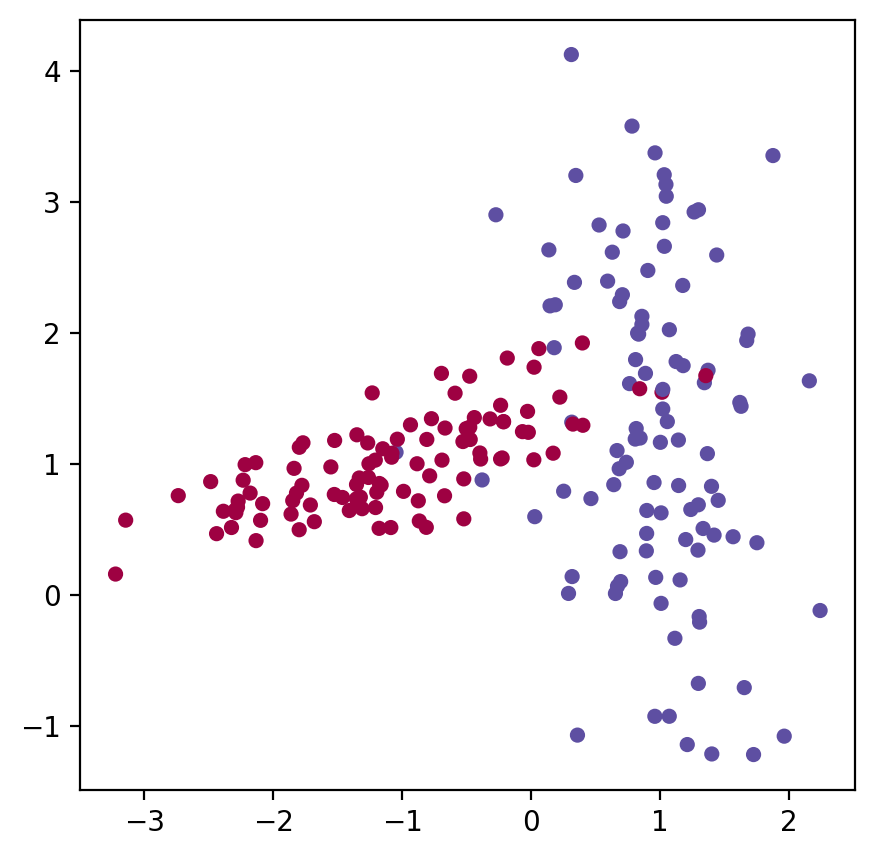

In [4]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

<hr style="border:2px solid gray">

# PyTorch

Welcome to the wonderful world of PyTorch! 

There are a lot of sharp edges, but PyTorch is still the least worst NN package.

Documentation: https://pytorch.org/docs/stable/nn.html

# write about the datatype Tensor. Important

We will firstly import `torch` and `torch.nn`. Note that module to import is not called pytorch - just torch.

In [5]:
import torch
import torch.nn as nn

torch.manual_seed(31337) # for reproducible runs, manually set the PRNG seed (pseudo-random number generator)

<div style="background-color: #FFF8C6">

Those who have a GPU on their computer can use the cell below to check whether CUDA is available. Read about CUDA [here](https://blogs.nvidia.com/blog/2012/09/10/what-is-cuda-2/).

In [6]:
# Do we have GPU acceleration?
torch.cuda.is_available()

False

## Linear Layer

The first thing we will build is a [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Data which is fed into a linear layer is linearly transformed, but not passed through an activation function.

To do this, we must specify the number of input 'legs' and output 'legs'.

In [7]:
m=2 # the number of input legs
n=1 # the number of output legs

linearlayer = nn.Linear(m,n)

#nn.linear will generate random weights and biases (here specified by our random seed)

We can call the function on a rank 1 tensor of length 2 (since there are 2 input legs), which should produce a rank 0 tensor, a.k.a. a scalar (since there is just 1 output leg).

In [8]:
linearlayer(torch.Tensor([1,1]))

tensor([0.2600], grad_fn=<AddBackward0>)

Above, we passed 1 instance of data which has 2 features, from which our linear layer produced 1 output.
We'll now pass 20 instances of data, so our output should have shape (20,1).

In [9]:
rt=torch.randn(20, m) 

In [10]:
linearlayer(rt).shape # and pass through the linear layer

torch.Size([20, 1])

### Inspecting the model

We can look at the weights and the biases of our model.
The model is an object, so has both data and method attributes.

In [11]:
print("W", linearlayer.weight)
print("b", linearlayer.bias)

W Parameter containing:
tensor([[ 0.4160, -0.0271]], requires_grad=True)
b Parameter containing:
tensor([-0.1289], requires_grad=True)


You will notice the `requires_grad` keyword here. This ust be True for a tensor if we are going to require the gradient to be calculated at any point in its existence. For weights and biases in a neural network, we definitely need this to be True, as the training process requires computation of gradients.

<hr style="border:2px solid gray">

# Binary Classifier in PyTorch


We will now recreate the binary classifier we made previously, now we have the full power of Pytorch to train it efficiently.

We need a model which consists of the linear layer from above, but with a Sigmoid activation function. When building a model, `nn.Sequential` allows you to specify all the layers and activation functions in order. E.g., below we pass out linear layer followed by the sigmoid function. The output from one layer becomes the input to the next one. The convenience of this feature becomes more apparent as the networks you build get bigger.

In [12]:
input_size=2 # two dimensional input
output_size=1 # one output

# Outputs from one activation function becomes the input for the next, chained together by forward() functions

model = nn.Sequential(nn.Linear(input_size,output_size), nn.Sigmoid())

print(model) 

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


<div style="background-color: #FFF8C6">

There is an alternative way to build arbitrary models in 
PyTorch by constructing a Python class, but this is considerably more complicated, involves a lot of 
object-orientated boilerplate code, and isn't necessary for 
simple architectures such as these.

As before with our linear layer, we input 2 arbitrary values, which should generate a scalar output

In [13]:
model(torch.tensor([0.0,0.0])) 

tensor([0.5906], grad_fn=<SigmoidBackward0>)

## Training

We will now train our neural network. For this, we need to define a loss function.
<div style="background-color:#C2F5DD">
    
See [the documentation from pytorch on loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) to find an applicable loss function and implement it below.
How does this compare to the self-coded loss function from the previous notebook? 

In [14]:
loss_function = nn.L1Loss()

When building a neural network in PyTorch, we need to define an optimizer. Recall that the training process often boils down to a multivariate minimisation problem - there are many pre-built algorithms which can carry this out for us efficiently. See the **where** for a description of schocastic gradient descent.

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) # you can experiment with different learning rates.

## DataSet and DataLoader

Here, we make use of [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) (very commonly used) and `TensorDataset`. You can read about them using the links attached, but the purpose of these objects, particularly the DataLoader, is to combine the various steps associated with loading in, processing and iterating through data.

The DataLoader object is an iterator, making it very well suited to the training process.

<div style="background-color:#C2F5DD">
    
Read the doucmentation for the DataLoader object, particularly the meaning of each keyword argument.

<div style="background-color: #FFF8C6">

For larger scale applications of machine learning which make use of GPUs, the DataLoader object is beneficial as it shuffles data around which means the data is fed more efficiently to the GPU.

In order to work with our generated datasets using PyTorch, we need them to be Tensor objects so we change the datatype below.

In [16]:
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

For stochastic gradient descent, we use **batches** of data. We can specify `batch_size` for DataLoader object.

In [1]:
trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

NameError: name 'torch' is not defined

## Training Loop

Now we're ready to train our model. As before, we will define a function which performs one full training loop. We can make this function take the number of epochs, `n`, as an argument.

In PyTorch, the training process for one batch in one epoch is generally as follows:

>1. Obtain batch from the DataLoader
>1. Perform a forward pass, i.e., make a prediction on the data using the model
>1. Compute the loss (how poor the prediction is) using the loss function
>1. Compute gradients (known as the backward pass)
>1. Use the gradients to perform a 'step' with the optimizer (hopefully toward the minimum of the loss function)

This is then repeated for all batches (in the case where we are using SGD as our optimizer) and the whole process is performed $n$ times for $n$ epochs.

The best way to see how to achieve this is by observing an example. See below.

In [17]:
# training loop

losses = []

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # 1. pull a batch from the loader
            
            y=model(Xtorch) # 2. forward pass through model
            loss=loss_function(y, Ytorch) # 3. compute the loss
            totalloss+=loss.detach() # detach method tells the machine not to track the gradient of this tensor
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        
        losses.append(totalloss)

Again we will visualise the decision boundary, so we can monitor how the model changes during the training process.

In [18]:
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

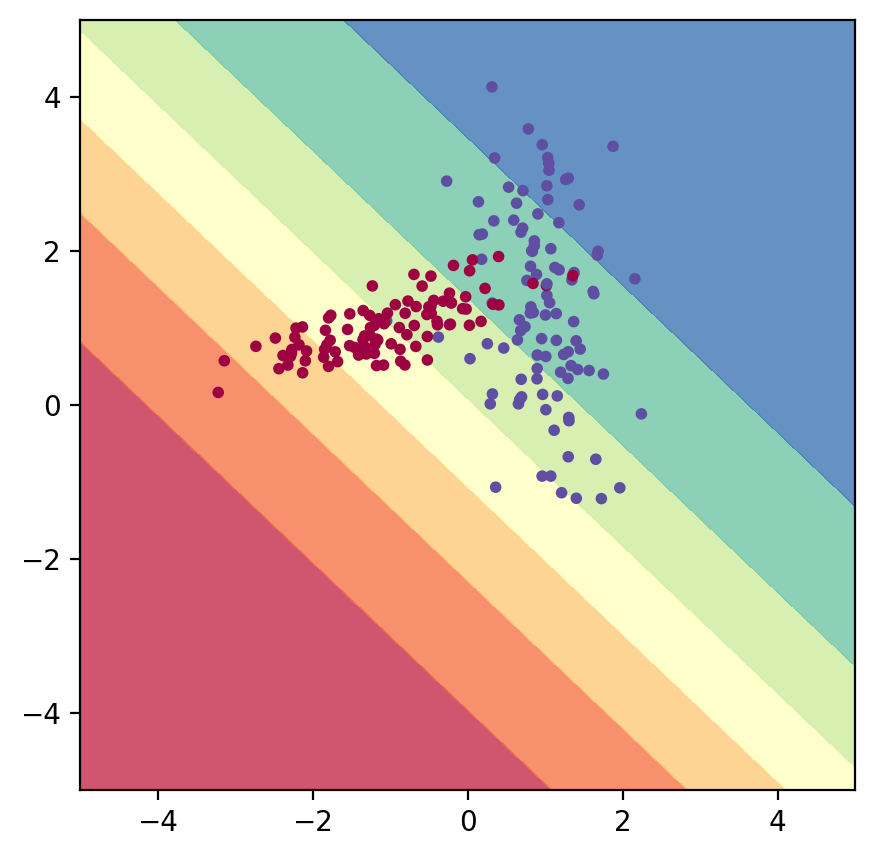

In [19]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

In the cell below, we run through 25 iterations. In each iteration, we plot the decision boundary (by making our model output predictions for every point in a grid) and then complete one training step.

If we did not want to visualise the decision boundary during the training process, we would simply have to run:

```python
train(25)
```

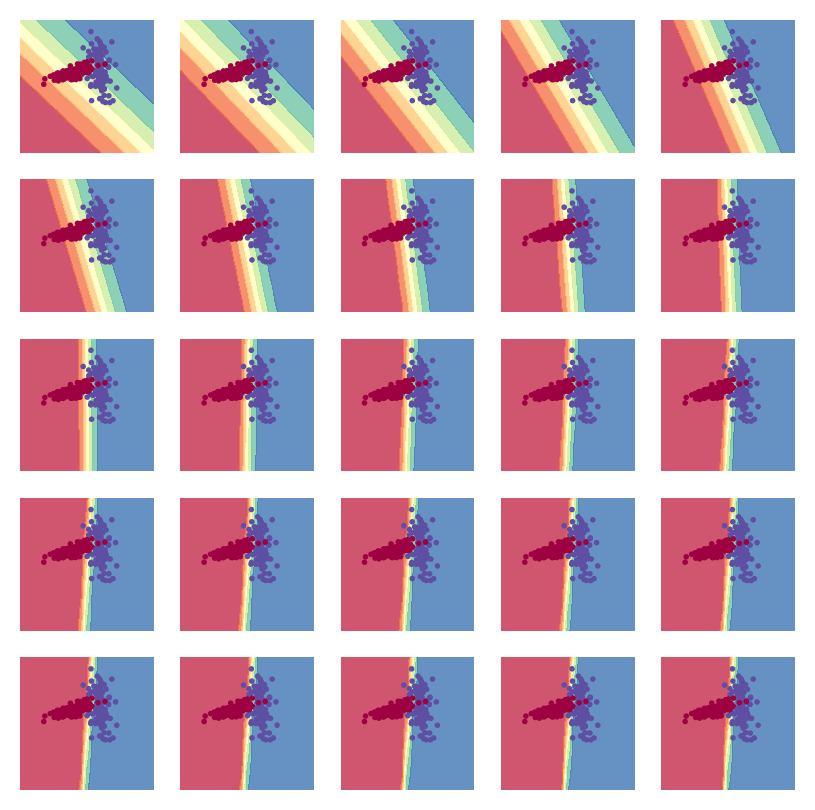

In [20]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


We can plot the loss as a function of the number of epochs. Whilst the above plot shows qualitatively that the model improves over the training process, the plot below shows it quantitatively.

(0.0, 1.513039055466652)

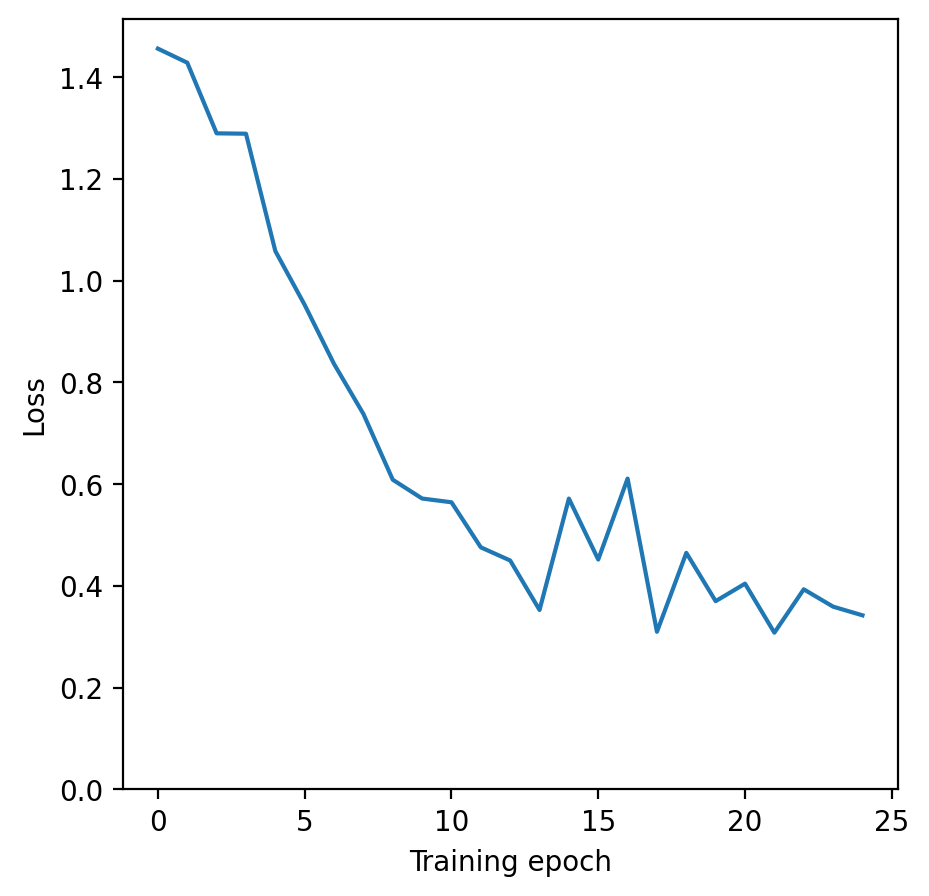

In [21]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

<div style="background-color:#C2F5DD">

What fraction of the training data do we correctly predict?

In [ ]:
print("Accuracy",(Ytorch == torch.round(model(Xtorch))).float().mean())

We can view all of the model's parameters using the following code:

In [23]:
# describe all parameters of model
for name,param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[ 9.3525, -0.5959]], requires_grad=True)
0.bias Parameter containing:
tensor([-0.8739], requires_grad=True)


<hr style="border:2px solid gray">

# Experiment with Manually Setting Weights

<div style="background-color:#C2F5DD">

The code block below allows us to maually set the weights of the model. Try and do this to correctly describe the data.

0.weight Parameter containing:
tensor([[0., 1.]], requires_grad=True)
0.bias Parameter containing:
tensor([0.], requires_grad=True)
Accuracy tensor(0.4350)


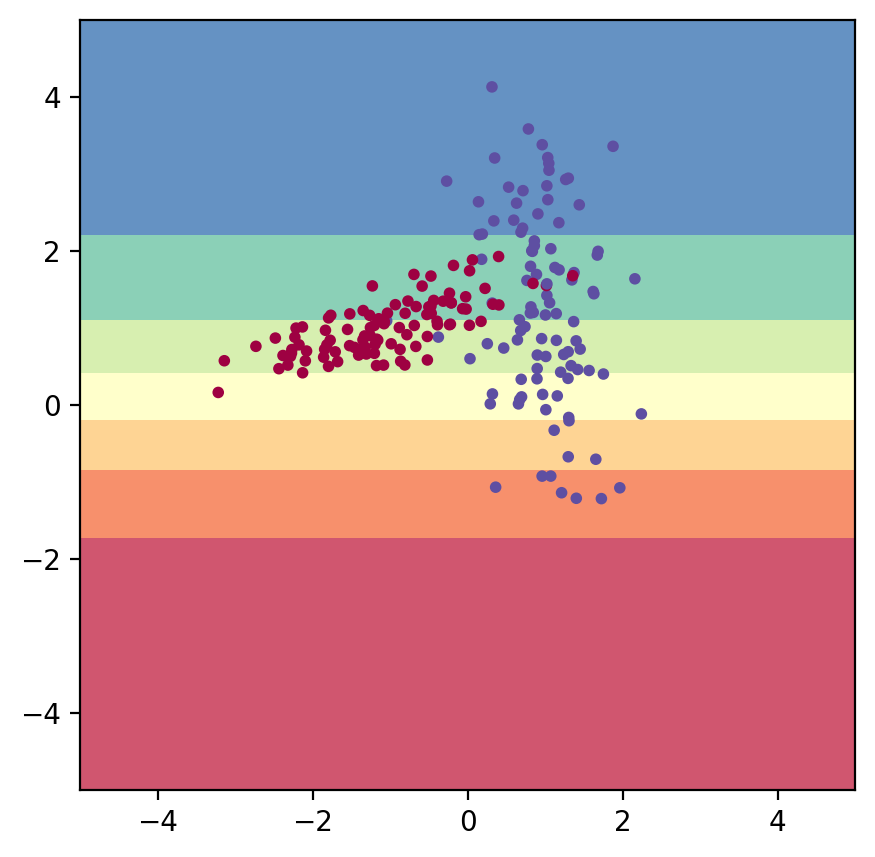

In [24]:
with torch.no_grad():
    model[0].weight[0,0]=0
    model[0].weight[0,1]=1
    model[0].bias[0]=0
    
for name,param in model.named_parameters():
    print(name, param)
    
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

# Accuracy - what fraction of the train data go we correctly predict?
print("Accuracy",(Ytorch == torch.round(model(Xtorch))).float().mean())

<hr style="border:2px solid gray">

# Multilayer perceptron

From our work thus far, we can see that a single neuron is only capable of linearly separating the input data. 

Instead we can make a multi-layer perceptron, which goes beyond the capabilities of a single neuron. It also allows us to begin learning a representation of the data which reduces the dimensionality.

This is where the term 'deep' learning comes from, once you have a deep network of many artificial neuron layers.

## Backpropagation

Now that we have moved onto multilayer networks, it is worth introducing the concept of backpropagation. Previously, when we found the rate of change of the loss function with respect to a parameter of our model, it was straight-forward. Now our network has (an) extra layer(s), the derivative of the loss function with respect to a weight has a less simple form due to the interdependence of neurons in successive layers.

Consider the following example.

<img src="https://studymachinelearning.com/wp-content/uploads/2019/12/crop_NN.jpg" width="450" height="300" />



Say we want to find the gradient of the loss function with respect to the weight $w_{11}$. Labelling our Loss as $L$, we want to find $$\frac{\partial L}{\partial w_{11}}$$

Note that we $a_{ij}$ is defined as the result of passing the output of the $j^{th}$ neuron of the $i^{th}$ layer through the activation function, $\sigma_i$.

i.e., 

$$a_{ij} = \sigma_i(z_{ij})$$
$$z_{ij} = \boldsymbol{x} \cdot \boldsymbol{w_j} + b_{ij}$$

A change in $w_{11}$ does bring about a change in the loss function (provided we don't have a dead neuron, more on this next week), but not in a direct sense. Changing $w_{11}$ causes a change in $z_{11}$, which in turn causes a change in $a_{11}$, which changes $z_{21}$ etc...

<div style="background-color: #FFF8C6">

In order, then, to calculate a gradient for this parameter, we need to use the chain rule.

$$\frac{\partial L}{\partial w_{11}} = \frac{\partial L}{\partial a_{21}} 
                                       \frac{\partial a_{21}}{\partial z_{21}}
                                       \frac{\partial z_{21}}{\partial a_{11}}
                                       \frac{\partial a_{11}}{\partial z_{11}}
                                       \frac{\partial z_{11}}{\partial w_{11}}$$
    
We can see here how we are almost traversing back, hence the name **backpropagation** and the name of the `backward()` method in PyTorch.

Im summary, to get the rate of change of the loss function with respect to a parameter, we need to know how, in turn, it changes with respect to everything which preceeds it. This leads to chains of derivatives.

## Generate New Dataset

Now we will generate a dataset which is not linearly separable, and hence requires slightly more 'heavy machinery' than the single layer perceptron.

In [25]:
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

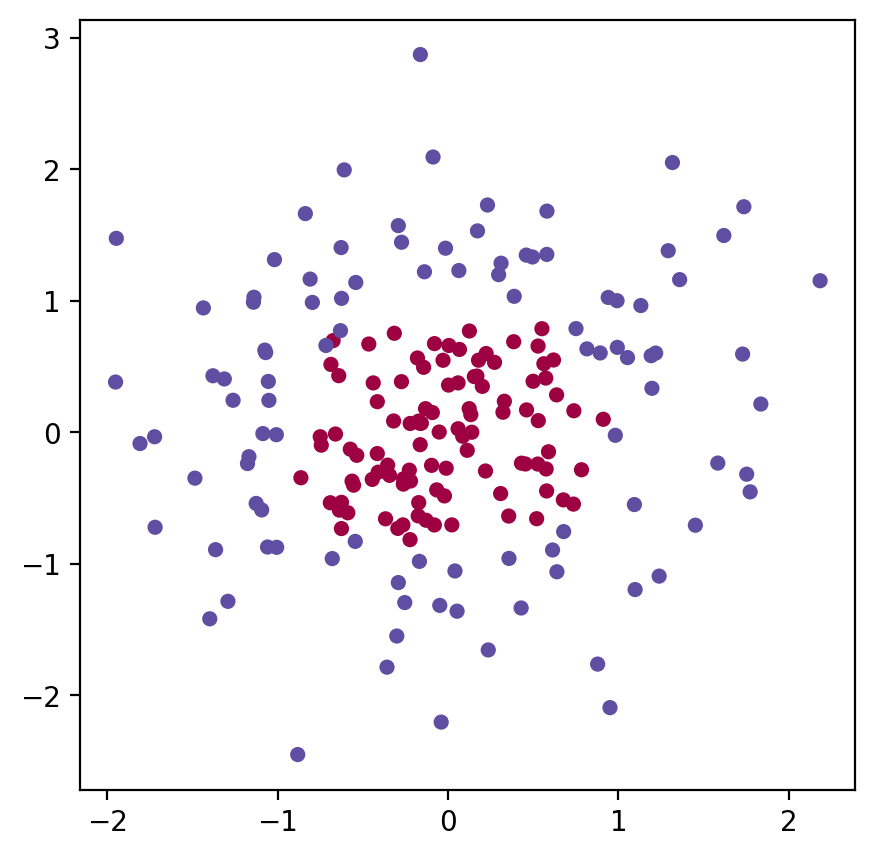

In [26]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

<div style="background-color:#C2F5DD">

Construct your new neural network with a 30-neuron hidden layer using the convenient `nn.sequential` functionality, using the tips in the cell below:
    
Print the model.

In [27]:
input_size=2 # two dimensional input
hidden_layer=30 # hidden layer
output_size=1 # one output

model = nn.Sequential( nn.Linear(input_size, hidden_layer), nn.ReLU(), nn.Linear(30,1), nn.Sigmoid())

print(model)


Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): Sigmoid()
)


The same as before, we can test that the model gives us outputs of the correct shape. Currently our model is untrained, so the values in the output do not have much meaning at this stage.

In [28]:
# this should work! Just two arb. data points, should generate a scalar output
model(torch.tensor([0.0,0.0])) 

tensor([0.5010], grad_fn=<SigmoidBackward0>)

## Training

To be ready to train our network - as we did last time - we need to define our optimzer, prepare our dataloader, implement a training function and visualise our decision boundaries (not necessary to train out model, but we are doing it here).

<div style="background-color:#C2F5DD">

Define the same loss function as we used before.

In [29]:
# See https://pytorch.org/docs/stable/nn.html#loss-functions

loss_function = nn.L1Loss()

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate

In [31]:
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

Training Loop Function:

In [34]:
losses=[]

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # pull a batch from the loader
            y=model(Xtorch) # forward pass through model
            loss=loss_function(y, Ytorch) # supervised learning
            totalloss+=loss.detach()
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        losses.append(totalloss)

In [35]:
# make a grid of predictions, for plotting the decision boundary
N=400
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) 
predict=predict.reshape( (N,N) ).detach()

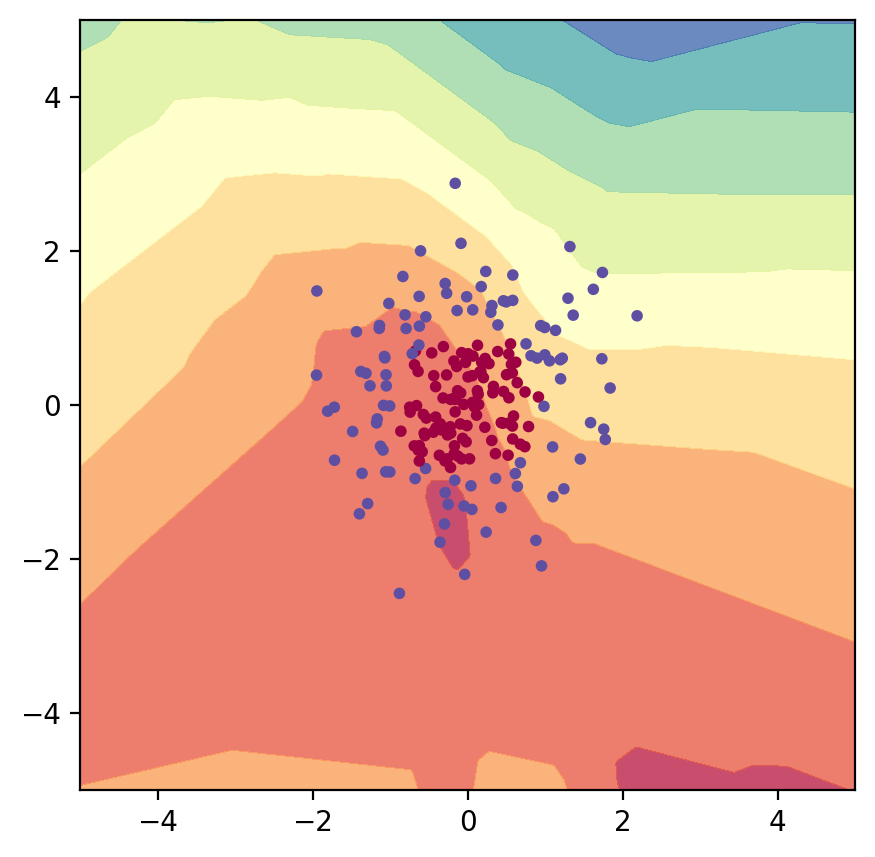

In [36]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

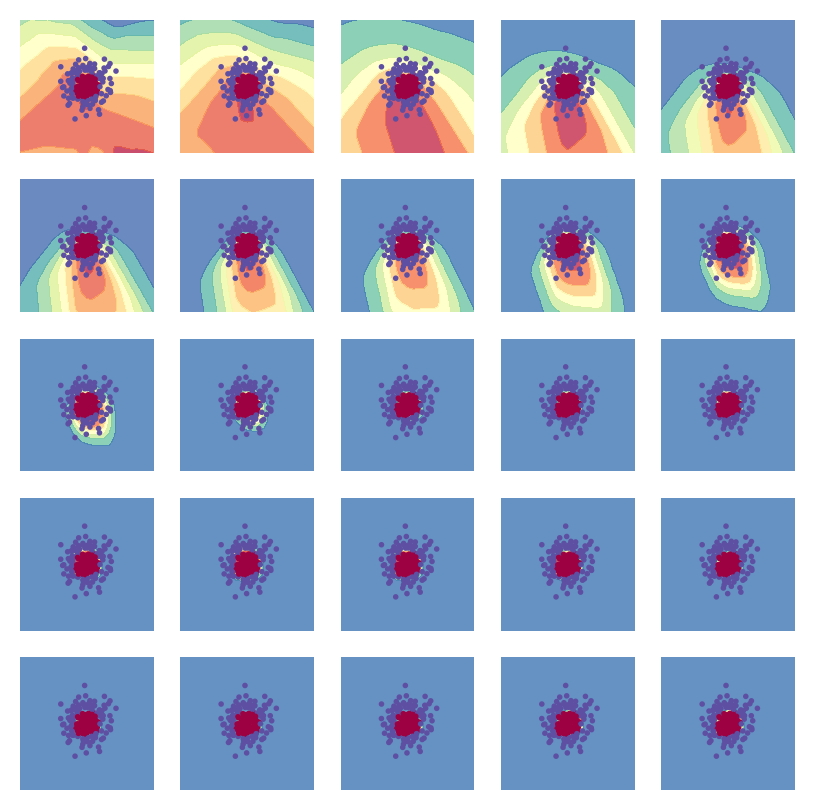

In [37]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)

(0.0, 6.6645676985383036)

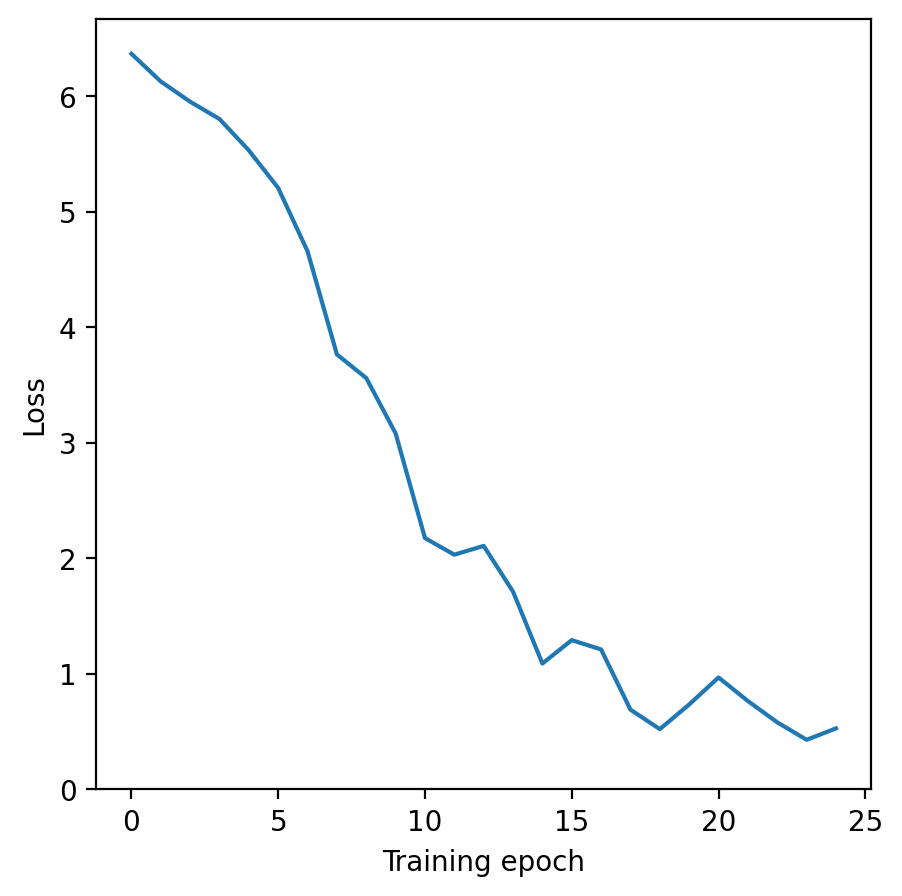

In [38]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

<div style="background-color:#C2F5DD">

Print the accuracy of the model.

In [ ]:
print("Accuracy",(Ytorch == torch.round(model(Xtorch))).float().mean())

Again we can inspect the model parameters. Note already the difference in size to our previous, smaller network.

In [40]:
model(Xtorch)

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0519e-10],
        [3.6218e-10],
        [1.0000e+00],
        [4.2084e-07],
        [5.6747e-05],
        [1.0107e-04],
        [8.3222e-11],
        [1.0000e+00],
        [1.0000e+00],
        [8.6888e-11],
        [7.3777e-06],
        [9.4862e-01],
        [2.2852e-11],
        [1.0000e+00],
        [5.1624e-11],
        [8.1616e-11],
        [1.4076e-08],
        [1.0000e+00],
        [1.0000e+00],
        [6.1721e-06],
        [5.1386e-11],
        [1.0000e+00],
        [1.0000e+00],
        [1.2000e-08],
        [1.0000e+00],
        [9.9598e-01],
        [4.1178e-13],
        [1.0000e+00],
        [1.3954e-10],
        [1.0000e+00],
        [9.9987e-01],
        [1.0000e+00],
        [4.1304e-03],
        [8.9176e-14],
        [7.5627e-13],
        [9.9999e-01],
        [1.0000e+00],
        [1.0000e+00],
        [2.1547e-14],
        [1.4372e-13],
        [9.9454e-01],
        [8.2983e-14],
        [6.2467e-05],
        [3